## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**GOSAT-based Top-down Total and Natural Methane Emissions**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/gosat-based-ch4budget-yeargrid-v1_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 4° x 5°
- **Temporal extent**: 2010 - 2022
- **Temporal resolution**: Annual
- **Unit**: Teragrams of methane per yea
- **Utility**: Climate Research

For more, visit the [GOSAT-based Top-down Total and Natural Methane Emissions](https://earth.gov/ghgcenter/data-catalog/gosat-based-ch4budget-yeargrid-v1) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the gridded methane emissions data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The NASA Carbon Monitoring System Flux (CMS-Flux) team analyzed remote sensing observations from Japan’s Greenhouse gases Observing SATellite (GOSAT) to produce the global Committee on Earth Observation Satellites (CEOS) CH₄ Emissions data product. They used an analytic Bayesian inversion approach and the GEOS-Chem global chemistry transport model to quantify annual methane (CH₄) emissions and their uncertainties at a spatial resolution of 1° by 1° and then projected these to each country for 2019.

For more information regarding this dataset, please visit the [GOSAT-based Top-down Total and Natural Methane Emissions](https://earth.gov/ghgcenter/data-catalog/gosat-based-ch4budget-yeargrid-v1) data overview page.

## Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

## Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for gosat budget methane. 
collection_name = "gosat-based-ch4budget-yeargrid-v1"

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=gosat-based-ch4budget-yeargrid-v1>

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2010 to December 2022. By looking at the `dashboard:time density`, we observe that the data is available for thirteen years.

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 13 items


In [5]:
# Examining the first item in the collection
items[0]

<Item id=gosat-based-ch4budget-yeargrid-v1-2022>

## Visual Comparison Across Time Periods

We will explore changes in methane emissions in urban egions. In this notebook, we'll explore the impacts of these emissions and explore these changes over time. We'll then visualize the outputs on a map using `folium`. 

In [6]:
# Now we create a dictionary where the start datetime values for each granule is queried more explicitly by year and month (e.g., 2020-02)
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["datetime"][:4]: item for item in collection.get_items()}

# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest

asset_name = "post-total"

In [7]:
# Choose a color map for displaying the first observation (event)
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

color_map = "rainbow" 

# Make a GET request to retrieve information for the date mentioned below
first_date = items["2019"]

# Extract collection name and item ID
collection_id = first_date.collection_id
item_id = first_date.id

object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)

{'max': 7.015276840482737, 'min': -1.1666732850607475}


In [8]:
# Make a GET request to retrieve information for the date mentioned below
_2019_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale=-0,3" #{rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
_2019_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/gosat-based-ch4budget-yeargrid-v1/items/gosat-based-ch4budget-yeargrid-v1-2019/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=post-total&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-0%2C3'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-182.5, -90.9777777777778, 177.5, 90.97777777777777],
 'center': [-2.5, -1.4210854715202004e-14, 0]}

## Map Out Selected Tiles

In [9]:
# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
map_ = folium.Map(location=(34, -118), zoom_start=2)

# January 2019
map_layer_2019 = TileLayer(
    tiles=_2019_tile["tiles"][0],
    attr="GHG",
    opacity=0.7,
)
map_layer_2019.add_to(map_)

map_

## Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [11]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [14]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"][:10],
    }

With the function above we can generate the statistics for the AOI.

In [15]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 167 ms, sys: 25.7 ms, total: 193 ms
Wall time: 7.06 s


In [16]:
stats[0]

{'statistics': {'b1': {'min': 0.45840875428297767,
   'max': 2.563434123331244,
   'mean': 1.3501146985384829,
   'count': 1.9799998998641968,
   'sum': 2.6732269679113765,
   'std': 0.5669339642223294,
   'median': 1.0878720382884925,
   'majority': 0.45840875428297767,
   'minority': 0.45840875428297767,
   'unique': 6.0,
   'histogram': [[2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0],
    [0.45840875428297767,
     0.6689112911878043,
     0.8794138280926309,
     1.0899163649974577,
     1.300418901902284,
     1.5109214388071108,
     1.7214239757119376,
     1.931926512616764,
     2.1424290495215907,
     2.352931586426417,
     2.563434123331244]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 6.0,
   'percentile_2': 0.45840875428297767,
   'percentile_98': 2.563434123331244}},
 'datetime': '2022-01-01'}

In [21]:
def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df = df.sort_values("datetime")
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
12,2010-01-01,0.522762,2.687274,1.615991,1.98,3.199662,0.718321,1.176316,0.522762,0.522762,6.0,"[[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",100.0,0.0,6.0,0.522762,2.687274,2010-01-01
11,2011-01-01,0.266725,2.235993,1.301970,1.98,2.577901,0.610951,0.960086,0.266725,0.266725,6.0,"[[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0,...",100.0,0.0,6.0,0.266725,2.235993,2011-01-01
10,2012-01-01,0.380561,2.395962,1.422850,1.98,2.817244,0.630351,1.037681,0.380561,0.380561,6.0,"[[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,...",100.0,0.0,6.0,0.380561,2.395962,2012-01-01
9,2013-01-01,0.532251,2.535978,1.568220,1.98,3.105075,0.655252,1.170210,0.532251,0.532251,6.0,"[[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",100.0,0.0,6.0,0.532251,2.535978,2013-01-01
8,2014-01-01,0.450945,2.553213,1.479748,1.98,2.929900,0.578882,1.198123,0.450945,0.450945,6.0,"[[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0,...",100.0,0.0,6.0,0.450945,2.553213,2014-01-01


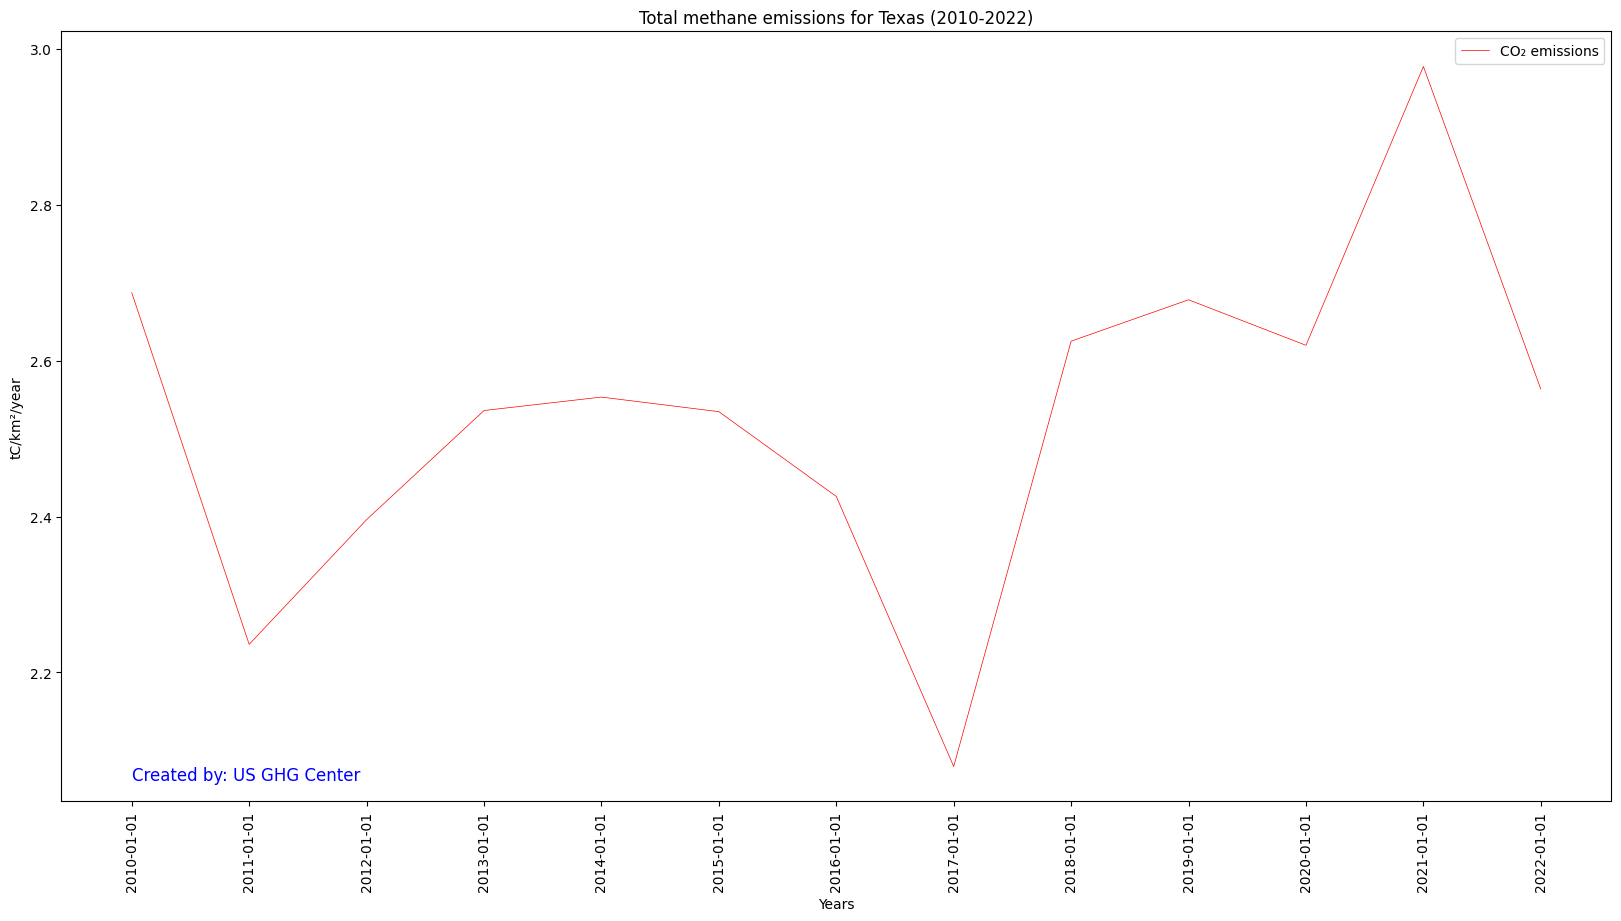

In [22]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="CO₂ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("tC/km²/year")
plt.xticks(rotation = 90)

# Insert title for the plot
plt.title("Total methane emissions for Texas (2010-2022)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text
    df["max"].min(),                  # Y-coordinate of the text
    # Text to be displayed
    "Created by: US GHG Center",      #example text            
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the GOSAT-based Top-down Total and Natural Methane Emissions dataset.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map the methane emission levels
5.  Generate zonal statistics for the area of interest (AOI)

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).